In [158]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
%autoreload 2
from delase import *
from dysts_simulation import Rossler
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from tqdm.auto import tqdm

from demo_utils import compute_lyaps, D_PR


In [222]:
num_trajs = 5
n_periods = 30
# pts_per_period = 1000
pts_per_period = 500
T = n_periods*pts_per_period
# param_list = [0.02, 0.28]
param_list = [0.02, 0.3]
traj_offset_sd = 1e-3
random_state = 42
param_name = "a"
noise = 1e-3
# noise = 0
transient = int(0.1*T)
train_window = int(0.6*T)
test_window = int(0.3*T)
# obs_noise = 1e-4
obs_noise = 0

trajectories = {}

eqs = {}
for param in param_list:
    params = dict(
        a=param,
        b=0.1,
        c=5.7
    )
    eq = Rossler(**params, random_state=random_state)
    eqs[param] = eq
    trajectories[param] = eq.make_trajectory(n_periods=n_periods, num_ics=num_trajs, pts_per_period=pts_per_period, noise=noise, traj_offset_sd=traj_offset_sd, verbose=True)
    trajectories[param] += obs_noise*np.random.randn(*trajectories[param].shape)
    

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [223]:
# A_signals = np.array([np.sqrt((trajectories[param]**2).mean(axis=(0, 1))) for param in param_list])
A_signals = np.array([np.sqrt((np.linalg.norm(trajectories[param], axis=-1)**2).mean()) for param in param_list])
A_noise = np.sqrt(3)*np.sqrt(noise + obs_noise)

In [224]:
SNR = 20*np.log10((A_signals/A_noise))
noise_percent = (A_noise/A_signals)*100

In [225]:
noise_percent, SNR
print(f"Parameter: {param_name} = {param_list[0]}")
print(f"Noise percent: {noise_percent[0]:.2f}%, SNR: {SNR[0]:.2f} dB")
print(f"Parameter: {param_name} = {param_list[1]}")
print(f"Noise percent: {noise_percent[1]:.2f}%, SNR: {SNR[1]:.2f} dB")

Parameter: a = 0.02
Noise percent: 0.76%, SNR: 42.34 dB
Parameter: a = 0.3
Noise percent: 0.43%, SNR: 47.43 dB


In [226]:
# dt = eq.dt
dt = eq.period/pts_per_period
t_inds = np.arange(n_periods*pts_per_period)
t_eval = t_inds*dt

train_inds = np.arange(transient, transient + train_window)
test_inds = np.arange(transient + train_window, transient + train_window + test_window)

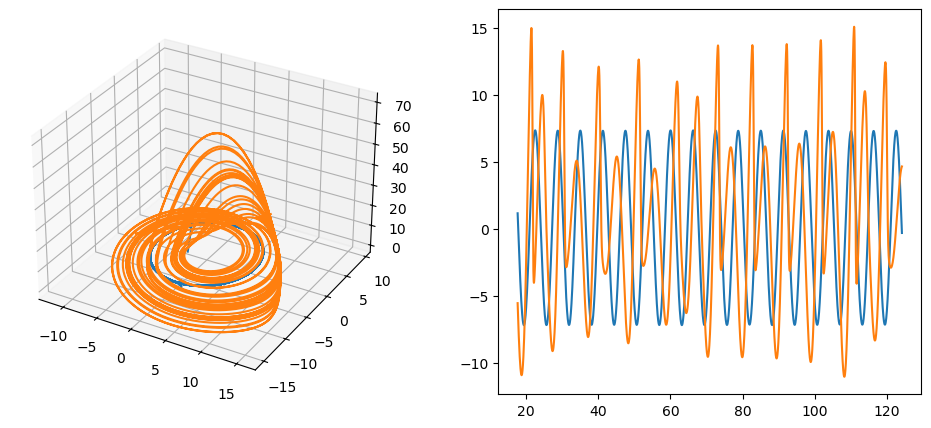

In [227]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
traj_num = -1
axs[0].remove()
axs[0] = fig.add_subplot(1, 2, 1, projection='3d')
for param, x in trajectories.items():
    ax = axs[0]
    ax.plot(x[traj_num, :, 0], x[traj_num, :, 1], x[traj_num, :, 2])

    ax = axs[1]
    ax.plot(t_eval[train_inds], x[traj_num, train_inds, 0])
    # ax.plot(t_eval[transient:transient + 100], x[traj_num, transient:transient + 100, 0])
plt.show()

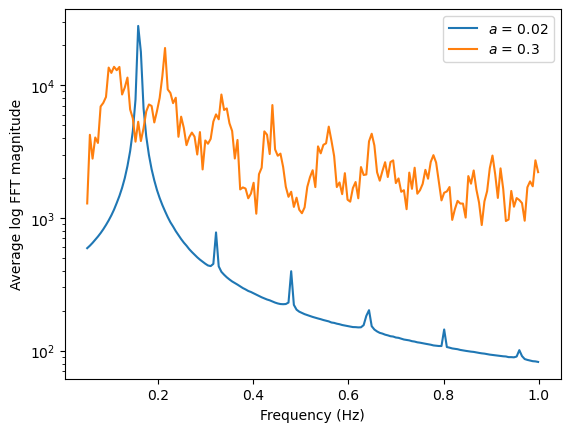

In [228]:
max_freq = 1
min_freq = 0.05
log = True

for param, x in trajectories.items():
    fft_mag = np.abs(np.fft.rfft(x.transpose(0, 2, 1).reshape(-1, x.shape[1]))).mean(axis=0)
    freqs = np.fft.rfftfreq(x.shape[1], d=dt)
    freq_inds = (freqs >= min_freq) & (freqs <= max_freq)
    plt.plot(freqs[freq_inds], fft_mag[freq_inds], label=fr"${param_name}$ = {param}")
plt.xlabel("Frequency (Hz)")

plt.legend()
if log:
    plt.yscale("log")
    plt.ylabel("Average log FFT magnitude")
else:
    plt.ylabel("Average FFT magnitude")

plt.show()

In [229]:
jacobians = {}

time_inds_jac = t_inds

for param, x in trajectories.items():
    eq = eqs[param]
    jacs = np.zeros((num_trajs, len(time_inds_jac), 3, 3))
    for num_traj in range(num_trajs):
        jacs[num_traj] = np.array([eq.jac(x[num_traj, t], t*dt) for t in time_inds_jac])
    jacobians[param] = jacs

In [230]:
lyaps = {}
for param, jacobian_mats in tqdm(jacobians.items()):
    lyap_vals = np.zeros((num_trajs, 3))
    for num_traj in range(num_trajs):
        lyap_vals[num_traj] = compute_lyaps(np.eye(3) + dt*jacobian_mats[num_traj], dt=dt)
        # lyap_vals[num_traj] = compute_lyapunov_exponents(np.eye(3) + dt*jacobian_mats[num_traj], dt=dt)
    lyaps[param] = lyap_vals

  0%|          | 0/2 [00:00<?, ?it/s]

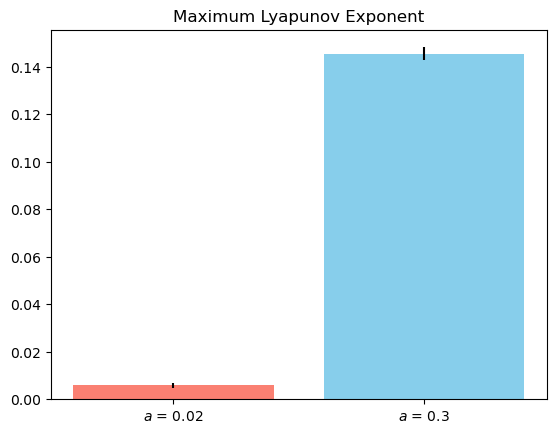

In [231]:
max_lyap_means = [lyaps[param][:, 0].mean() for param in param_list]
max_lyap_ses = [lyaps[param][:, 0].std()/np.sqrt(lyaps[param].shape[0]) for param in param_list]
labels = [fr"${param_name}$ = {param}" for param in param_list]
colors = ['skyblue' if param == np.max(param_list) else 'salmon' for param in param_list]
plt.bar(labels, max_lyap_means, yerr=max_lyap_ses, color=colors)

plt.title('Maximum Lyapunov Exponent')

plt.show()

# Stability Analysis

In [232]:
def floor(x, eps=1e-8):
    if isinstance(x, torch.Tensor):
        return torch.floor(x + eps).type(torch.int64)
    else:
        return np.floor(x + eps).astype(int)

In [233]:
max_freq = (1/(dt))/2

# n_delays_vals = np.arange(1, 16)
# rank_vals = np.arange(1, 16)

n_delays_vals = np.concat([np.arange(1, 16), np.arange(20, 61, 10)])
rank_vals = np.concat([np.arange(1, 16), np.arange(20, 61, 10)])

# n_delays_vals = np.concat([np.arange(1, 16), np.arange(20, 151, 10)])
# rank_vals = np.concat([np.arange(1, 16), np.arange(20, 151, 10)])

delay_interval = 1

all_delase_results = []

iterator = tqdm(total=num_trajs*len(param_list)*len(n_delays_vals)*len(rank_vals))
num_params_all = {}
for num_traj in range(num_trajs):
    # print("-"*20)
    # print(f"NUM_TRAJ = {num_traj}")
    delase_results = {}
    num_params_all[num_traj] = {}
    for param in param_list:
        # print("-"*20)
        # print(f"MU = {mu}")
        x = trajectories[param]
        x = x[num_traj]
        # x = x[::subsample]
        x = x[:, [0]] # partial observation
        
        aic_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
        mase_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
        stab_mean_mat3 = np.zeros((len(n_delays_vals), len(rank_vals)))
        stab_mean_mat10p = np.zeros((len(n_delays_vals), len(rank_vals)))
        delase_evals_mat3 = np.zeros((len(n_delays_vals), len(rank_vals)))
        delase_evals_mat10p = np.zeros((len(n_delays_vals), len(rank_vals)))

        num_params_all[num_traj][param] = {}
        
        for i, n_delays in enumerate(n_delays_vals):
            delase = DeLASE(x[train_inds], n_delays=n_delays, rank=n_delays*x.shape[-1], delay_interval=delay_interval, dt=dt, max_freq=max_freq, max_unstable_freq=max_freq, device='cuda')
            delase.DMD.compute_hankel()
            delase.DMD.compute_svd()
            num_params_all[num_traj][param][n_delays] = {}
            for j, rank in enumerate(rank_vals):
                if rank <= n_delays*x.shape[-1]:
                    
                    delase.DMD.compute_havok_dmd(rank=rank)
                    preds = delase.DMD.predict(x[test_inds])
                    aic_mat[i, j] = float(aic(torch.from_numpy(x[test_inds]).cuda()[..., (n_delays - 1)*delay_interval + 1:, :], preds[..., (n_delays - 1)*delay_interval + 1:, :], k=rank**2).cpu().numpy())
                    mase_mat[i, j] = float(mase(torch.from_numpy(x[test_inds]).cuda()[..., (n_delays - 1)*delay_interval + 1:, :], preds[..., (n_delays - 1)*delay_interval + 1:, :]).cpu().numpy())
                    delase.get_stability()
                    stab_mean_mat3[i, j] = delase.stability_params[:3].mean().cpu().numpy()
                    # if rank == 30 and n_delays == 30:
                    #     print(len(delase.stability_params))
                    #     print(0.1*len(delase.stability_params))
                    #     print(floor(0.1*len(delase.stability_params)))
                    num_params = np.min((floor(0.1*len(delase.stability_params)), rank))
                    # num_params = np.min((floor(0.1*n_delays*x.shape[-1]), rank))
                    num_params = np.max([num_params, 1])
                    num_params_all[num_traj][param][n_delays][rank] = num_params
                    stab_mean_mat10p[i, j] = delase.stability_params[:num_params].mean().cpu().numpy()

                    I = torch.eye(delase.DMD.A_havok_dmd.shape[0]).cuda()
                    evals = torch.linalg.eigvals((delase.DMD.A_havok_dmd - I)/dt)
                    evals, freqs = torch.real(evals), torch.imag(evals)/(2*np.pi)
                    sort_inds = torch.flip(torch.sort(evals).indices, dims=(0,))
                    evals, freqs = evals[sort_inds], freqs[sort_inds]
                    freq_inds = freqs <= max_freq
                    evals = evals[freq_inds]
                    freqs = freqs[freq_inds]
                    delase_evals_mat3[i, j] = evals[:3].mean().cpu().numpy()
                    num_evals = np.min((int(0.1*len(evals)), rank))
                    num_evals = np.max([num_evals, 1])
                    delase_evals_mat10p[i, j] = evals[:num_evals].mean().cpu().numpy()
                    
                else:
                    aic_mat[i, j] = np.inf
                    mase_mat[i, j] = np.inf
                iterator.update()
    
        delase_results[param] = dict(
            train_inds=train_inds,
            test_inds=test_inds,
            aic_mat=aic_mat,
            mase_mat=mase_mat,
            stab_mean_mat3=stab_mean_mat3,
            stab_mean_mat10p=stab_mean_mat10p,
            delase_evals_mat3=delase_evals_mat3,
            delase_evals_mat10p = delase_evals_mat10p
        )

    all_delase_results.append(delase_results)
    
iterator.close()

  0%|          | 0/4000 [00:00<?, ?it/s]

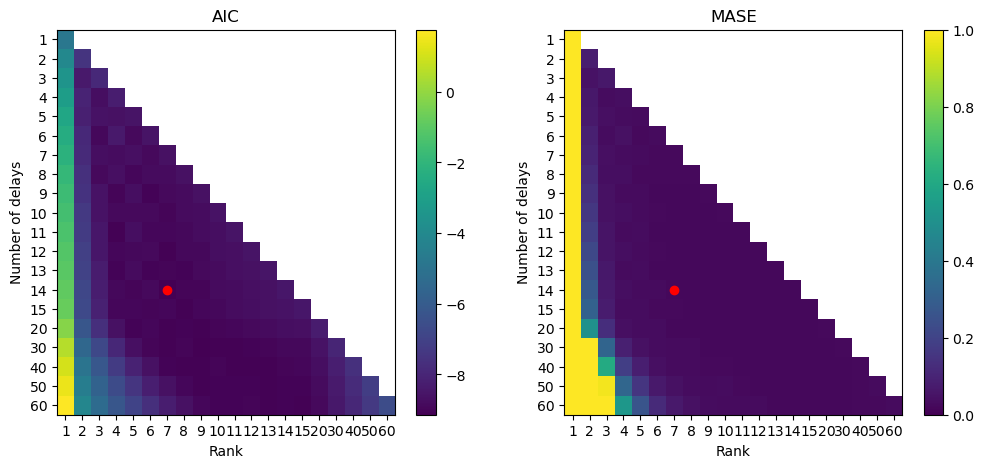

In [234]:
params_to_use = param_list
metric_to_use = 'aic'

aic_mat_all = np.ones((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))
mase_mat_all = np.ones((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))
for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for ind, param in enumerate(params_to_use):
        aic_mat_all[num_traj, ind] = delase_results[param]['aic_mat']
        mase_mat_all[num_traj, ind] = delase_results[param]['mase_mat']
aic_mat = aic_mat_all.mean(axis=(0, 1))
mase_mat = mase_mat_all.mean(axis=(0, 1))
if metric_to_use == 'aic':
    i, j = np.unravel_index(aic_mat.argmin(), shape=aic_mat.shape)
elif metric_to_use == 'mase':
    i, j = np.unravel_index(mase_mat.argmin(), shape=mase_mat.shape)
else:
    raise ValueError("Invalid metric")
n_delays = n_delays_vals[i]
rank = rank_vals[j]
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
im = ax.imshow(aic_mat, aspect='auto')
ax.scatter(j, i, c='r')
ax.set_xticks(np.arange(len(rank_vals)), rank_vals)
ax.set_yticks(np.arange(len(n_delays_vals)), n_delays_vals)
fig.colorbar(im, ax=ax)
ax.set_title('AIC')
ax.set_xlabel('Rank')
ax.set_ylabel('Number of delays')

ax = axs[1]
norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
im = ax.imshow(mase_mat, aspect='auto', norm=norm)
ax.scatter(j, i, c='r')
ax.set_xticks(np.arange(len(rank_vals)), rank_vals)
ax.set_yticks(np.arange(len(n_delays_vals)), n_delays_vals)
fig.colorbar(im, ax=ax)
ax.set_title('MASE')
ax.set_xlabel('Rank')
ax.set_ylabel('Number of delays')
plt.show()

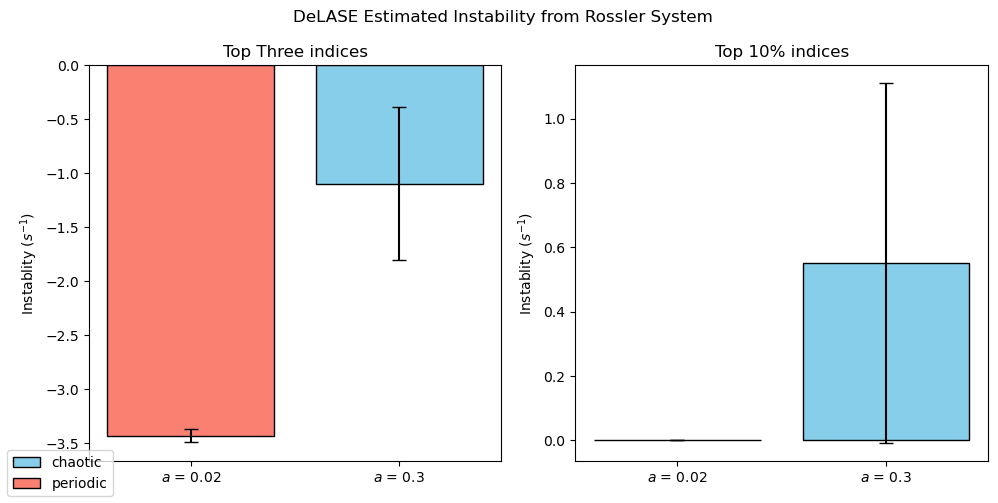

In [235]:
stab_means_3 = np.zeros((num_trajs, len(params_to_use)))
stab_means_10p = np.zeros((num_trajs, len(params_to_use)))
delase_evals_3 = np.zeros((num_trajs, len(params_to_use)))
delase_evals_10p = np.zeros((num_trajs, len(params_to_use)))

for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for ind, param in enumerate(params_to_use):
        stab_means_3[num_traj, ind] = delase_results[param]['stab_mean_mat3'][i, j]
        stab_means_10p[num_traj, ind] = delase_results[param]['stab_mean_mat10p'][i, j]
        delase_evals_3[num_traj, ind] = delase_results[param]['delase_evals_mat3'][i, j]
        delase_evals_10p[num_traj, ind] = delase_results[param]['delase_evals_mat10p'][i, j]

# Create the scatter plot with error bars

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plt.errorbar(np.arange(len(pairs_to_use)), mean_vals, yerr=se_vals, fmt='o', ecolor='r', capsize=5)
colors = ['skyblue' if param == np.max(params_to_use) else 'salmon' for param in params_to_use]

ax = axs[0]
mean_vals = stab_means_3.mean(axis=0)
se_vals = stab_means_3.std(axis=0)/np.sqrt(stab_means_3.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top Three indices")

ax = axs[1]
mean_vals = stab_means_10p.mean(axis=0)
se_vals = stab_means_10p.std(axis=0)/np.sqrt(stab_means_10p.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top 10% indices")

fig.suptitle("DeLASE Estimated Instability from Rossler System")

# Create legend
legend_labels = {'chaotic': "chaotic", 'stable': 'periodic'}
legend_handles = [plt.Rectangle((0,0),1,1, color='skyblue', ec='black', lw=1, label=legend_labels['chaotic']),
                  plt.Rectangle((0,0),1,1, color='salmon', ec='black', lw=1, label=legend_labels['stable'])]
fig.legend(handles=legend_handles, loc='lower left')
plt.tight_layout()
plt.show()

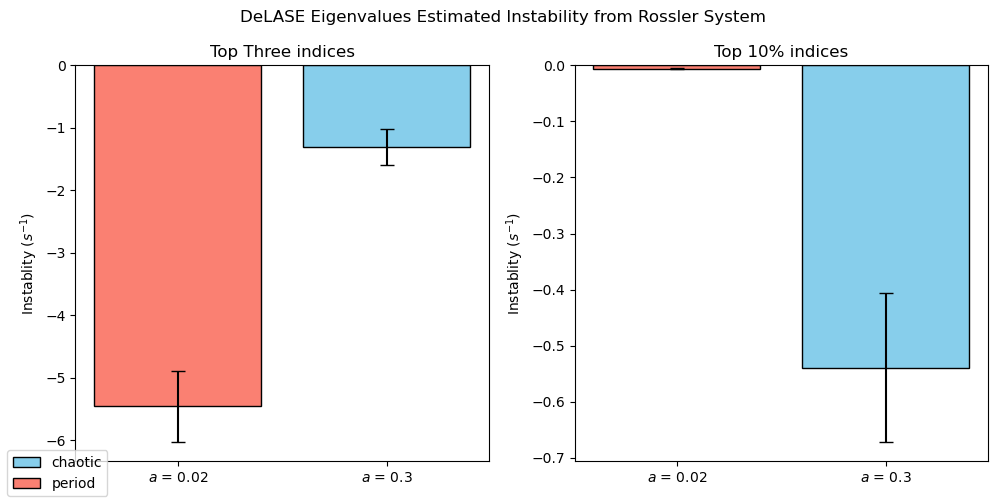

In [236]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plt.errorbar(np.arange(len(pairs_to_use)), mean_vals, yerr=se_vals, fmt='o', ecolor='r', capsize=5)
colors = ['skyblue' if param == np.max(params_to_use) else 'salmon' for param in params_to_use]

ax = axs[0]
mean_vals = delase_evals_3.mean(axis=0)
se_vals = delase_evals_3.std(axis=0)/np.sqrt(delase_evals_3.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

# ax.set_xlabel("$a$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top Three indices")

ax = axs[1]
mean_vals = delase_evals_10p.mean(axis=0)
se_vals = delase_evals_10p.std(axis=0)/np.sqrt(delase_evals_10p.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

# ax.set_xlabel("$a$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top 10% indices")

fig.suptitle("DeLASE Eigenvalues Estimated Instability from Rossler System")

# Create legend
legend_labels = {'chaotic': "chaotic", 'stable': 'period'}
legend_handles = [plt.Rectangle((0,0),1,1, color='skyblue', ec='black', lw=1, label=legend_labels['chaotic']),
                  plt.Rectangle((0,0),1,1, color='salmon', ec='black', lw=1, label=legend_labels['stable'])]
fig.legend(handles=legend_handles, loc='lower left')
plt.tight_layout()
plt.show()

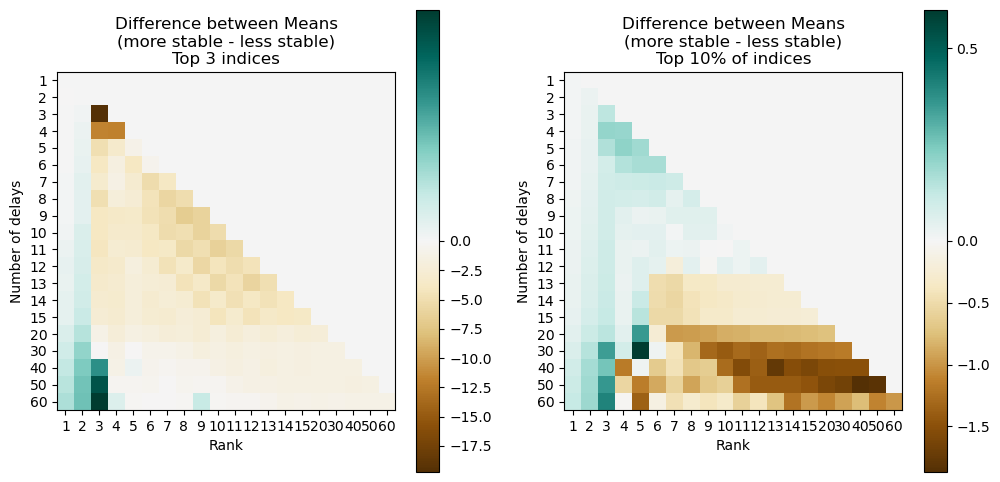

In [237]:
stab_means_all10p = np.zeros((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))
stab_means_all3 = np.zeros((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))

for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for ind, param in enumerate(params_to_use):
        stab_means_all10p[num_traj, ind] = delase_results[param]['stab_mean_mat10p']
        stab_means_all3[num_traj, ind] = delase_results[param]['stab_mean_mat3']
    

stab_all_mean10p = stab_means_all10p.mean(axis=0)
stab_all_se10p = stab_means_all10p.std(axis=0)/np.sqrt(num_trajs)

stab_all_mean3 = stab_means_all3.mean(axis=0)
stab_all_se3 = stab_means_all3.std(axis=0)/np.sqrt(num_trajs)

diff10p = stab_all_mean10p[0] - stab_all_mean10p[1]
diff3 = stab_all_mean3[0] - stab_all_mean3[1]
# print(diff.min(), diff.max())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)

if diff3.max() <= 0:
    norm = TwoSlopeNorm(vmin=diff3.min(), vcenter=0, vmax=-diff3.min())
else:
    norm = TwoSlopeNorm(vmin=diff3.min(), vcenter=0, vmax=diff3.max())
# norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)

plt.imshow(diff3, cmap='BrBG', norm=norm)
plt.xticks(np.arange(len(rank_vals)), rank_vals)
plt.yticks(np.arange(len(n_delays_vals)), n_delays_vals)
plt.colorbar()
plt.title("Difference between Means\n(more stable - less stable)\nTop 3 indices")
plt.xlabel('Rank')
plt.ylabel('Number of delays')

plt.subplot(1, 2, 2)

if diff10p.max() <= 0:
    norm = TwoSlopeNorm(vmin=diff10p.min(), vcenter=0, vmax=-diff10p.min())
else:
    norm = TwoSlopeNorm(vmin=diff10p.min(), vcenter=0, vmax=diff10p.max())
# norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)

plt.imshow(diff10p, cmap='BrBG', norm=norm)
plt.xticks(np.arange(len(rank_vals)), rank_vals)
plt.yticks(np.arange(len(n_delays_vals)), n_delays_vals)
plt.colorbar()

plt.title("Difference between Means\n(more stable - less stable)\nTop 10% of indices")
plt.xlabel('Rank')
plt.ylabel('Number of delays')

plt.show()

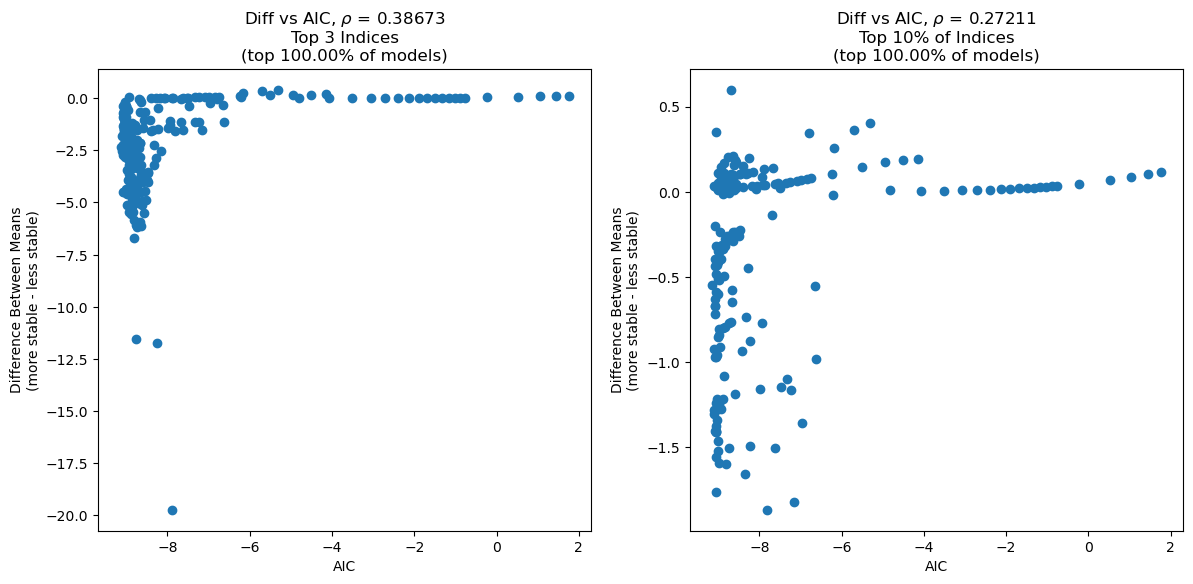

In [238]:
top_percent = 1
aic_min = aic_mat[aic_mat < np.inf].min()
aic_max = np.percentile(aic_mat[aic_mat < np.inf], top_percent*100)
aic_all = aic_mat[aic_mat < np.inf].flatten()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
diff_all = diff3[aic_mat < np.inf].flatten()
aic_inds = (aic_all >= aic_min) & (aic_all <= aic_max)

plt.scatter(aic_all[aic_inds], diff_all[aic_inds] )
plt.xlabel('AIC')
plt.ylabel('Difference Between Means\n(more stable - less stable)')

rho = pearsonr(aic_all[aic_inds], diff_all[aic_inds]).statistic
plt.title(fr"Diff vs AIC, $\rho$ = {rho:.5f}"+ f"\nTop 3 Indices\n(top {top_percent*100:.2f}% of models)")


plt.subplot(1, 2, 2)
diff_all = diff10p[aic_mat < np.inf].flatten()
aic_inds = (aic_all >= aic_min) & (aic_all <= aic_max)

plt.scatter(aic_all[aic_inds], diff_all[aic_inds] )
plt.xlabel('AIC')
plt.ylabel('Difference Between Means\n(more stable - less stable)')

rho = pearsonr(aic_all[aic_inds], diff_all[aic_inds]).statistic
plt.title(fr"Diff vs AIC, $\rho$ = {rho:.5f}"+ f"\nTop 10% of Indices\n(top {top_percent*100:.2f}% of models)")


plt.show()

In [103]:
participation_ratios = {}
for param, traj in trajectories.items():
    print("-"*20)
    print(f"PARAM = {param}")
    print("-"*20)
    print("Computing distance matrix...")
    pts = traj.reshape(-1, traj.shape[-1])
    dist_matrix = cdist(pts, pts)
    print("Done!")
    r = np.std(dist_matrix) / 5
    pts = traj.reshape(-1, traj.shape[-1])
    participation_ratios[param] = D_PR(pts, r, dist_matrix=dist_matrix, verbose=True)

--------------------
PARAM = 0.02
--------------------
Computing distance matrix...
Done!


  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [273]:
print(participation_ratios)

{0.02: np.float64(1.2247167901552762), 0.3: np.float64(1.8650630525620113)}


In [87]:
num_params_all[0][0.02][30][30]

np.int64(2)

# Notes to include
- it's worth going well past where your optimal parameters are found, to see if the finding is consistent beyond that
- this is especially true if there are inconsistent findings across the hyperparameters
- Using 10% of the characteristic roots with the default settings seems to be a reasonable choice, most of the time. But it's always important to see what the results are when using other portions of the spectrum, to check consistency.